# Explore convection patterns on countably small discrete grid 
### with fixed area coverage of discrete updrafts 

Rank-sort probability $P_w$ to place exactly 4 discrete Boolean updrafts in a 4x4 grid. Those can have 16x15x14x13 = 43680 configurations. Many of these are redundant, just transposed or rotated for instance. 31 stand out based on the mean horizontal divergent wind speed on the grid, and the variance in the number of face-neightbors (not diagonal neighbors). 

In a time-iteration game, define a transition probability with W,R,E,F parameters as: 

`Pw(x,y, t+1) = W w(x,y, t) + R Noise + E N4neigh(x,y, t) + F |V(x,y, t)|`

Pure W gives a diagonal TPM, totally stuck from initial conditions. Pure R makes an unconditional result, categorized by how numerous the equivalency classes are. E and F are pattern-conditional terms, which might lead into persistent forms of organization, whether stationary or propagating or oscillating or perhaps chaotically transitioning? Only a computer can tell us, as [Wolfram](https://atlas.wolfram.com/01/01/) in the unsolvability of even 1D has shown! Safe from analytic mathematicians and their scowls at how much we didn't learn formally... :) 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import label, generate_binary_structure
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.signal import convolve2d # to find n_neighbors 
import gif 
from IPython.display import Image

In [2]:
# Functions for plotting, n_neighbors, labelcount (#blobs)

def tileplot(arr,N=2, **kwargs): 
    plt.figure( figsize=(2,2))
    plt.pcolormesh( np.tile(arr, (N, N)), cmap='RdBu_r', shading='nearest', \
                    vmin=-np.max(np.abs(arr)),vmax=np.max(np.abs(arr)), **kwargs);
    
def tilepcolor(arr,N=2, NLEV=23, **kwargs): 
    plt.pcolormesh( np.tile(arr, (N, N)), shading='nearest',**kwargs);

def tilecon(arr,N=2, NLEV=23, **kwargs): 
    plt.contourf( np.tile(arr, (N, N)), cmap='RdBu_r',levels=NLEV, **kwargs);
      
def tilequiv(u,v,N=2, pivot='mid', **kwargs): 
    plt.quiver( np.tile(u, (N, N)), np.tile(v, (N, N)), **kwargs);

def labelcount (arr,N=2, **kwargs): 
    return label( np.tile(arr, (N, N)), **kwargs)[1]

def labelcount_diag (arr,N=2, **kwargs): 
    s = generate_binary_structure(2,2)
    return label( np.tile(arr, (N, N)), structure=s, **kwargs)[1]

def n_neighbors(w, max=4):
    # default case: 4 neighbors
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]      ])
    if (max==8): 
        kernel = np.ones((3, 3)); kernel[1, 1] = 0  # Exclude the center cell itself
    if (max==9): 
        kernel = np.ones((3, 3))
   
    # Apply the convolution
    neigh = convolve2d(w, kernel, mode='same', boundary='wrap')
    return(neigh)

In [3]:
# Fourier transform of w returns what, Chi, u, v

def what_Chi_u_v(w):
    
    what = np.fft.fft2(w-np.mean(w))  # Subtract the mean 
    ky, kx = np.fft.fftfreq(w.shape[0]), np.fft.fftfreq(w.shape[1])
    ky2,kx2 = np.meshgrid(ky, kx, indexing='ij')
    kk2 = np.sqrt(kx2**2 + ky2**2)
    
    Chi = np.fft.fft2 (what / (kk2+1e-9)) # Division by zero avoided, only occurs for what=0
    
    Chi = np.roll( np.flipud( np.fliplr(Chi)) ,(1,1),axis=(0,1))  # Graphical fix! Kangfirmed!
    
    # Adjust the boundaries for periodicity and compute gradient, then trim it 
    Chi_padded = np.pad(Chi.real, ((1, 1), (1, 1)), mode='wrap')
    grad_x, grad_y = np.gradient(Chi_padded)
    v = grad_x[1:-1, 1:-1]
    u = grad_y[1:-1, 1:-1]
    
    # KE once we trust it 
    KE = (u**2 + v**2)/2

    return what,Chi,u,v

In [4]:
NX = 4 # Make a test 4 in 4x4 convection field 
NCELLS = 4
w = np.zeros((NX,NX))
w.ravel()[np.random.choice(NX*NX, NCELLS, replace=False)] = 1

what,Chi,u,v = what_Chi_u_v(w)

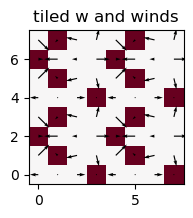

In [5]:
tileplot(w,2); tilequiv( u,v,2 ); plt.title('tiled w and winds');

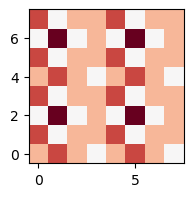

In [6]:
tileplot(n_neighbors(w)) #; plt.colorbar();

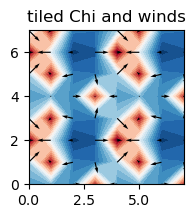

In [7]:
plt.figure(figsize=(2,2))
tilecon(Chi.real,2); tilequiv( u,v,2 ); plt.title('tiled Chi and winds');

# How many unique configurations are possible?

For a given periodic domain size, how many distinct configs are there? Math could perhaps count the equivalency classes, with the number of transpositions = NX + NY and the number of rotations = 4, but some of those are perhaps redundant...confused about it, let's see what the numbers say, especially cared-about things like KE or mean wind speed. 

**MeanVs** seems to be the most discriminating quantity about a configuration

The formula for combinations without replacement (AS HERE) is:
`C(n,r)= r!(n−r)! / n!`, while the formula for combinations with replacement is:
`C′(n,r)= r!(n−1)!/(n+r−1)!`


In [8]:
from scipy.special import comb
# Calculate combinations of 16 choose 4
n = 16; k = 4
print(comb(n, k))   # repetition=True for selection WITH replacement

1820.0


In [9]:
16*15*14*13

43680

In [10]:
# Unique combinations 
n = 16; k = 4
print( comb(n, k) )

1820.0


<Figure size 1200x1200 with 0 Axes>

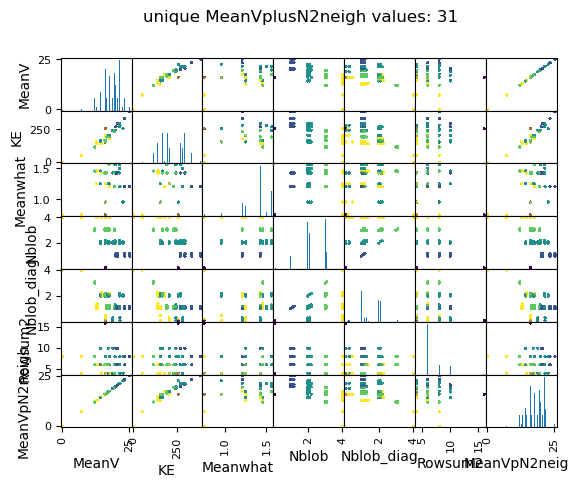

In [24]:
# Make N random configurations and collect stats (KE, etc.) 
NX = 4; NCELLS = 4
NSAMP = 100000  # unique configs: 31 for NX=NCELLS=4, 306 for 5, 5149?(500000) for 6

#initialise list of features
ws = []   # list OF w ARRAYS 
vs = []   # list OF v ARRAYS 
us = []   # list OF u ARRAYS 
Nblobs= []
Nblobs_diag= []
N2neighs = []  # variance of neighbor numbers
KEs = []
meanVs = []
Meanwhats=[]
Rowsum2s= [] # variance of row sums 

# collect tiled image frames in a gif
frames = []  # one giant gif, for perusing not playing
@gif.frame
def plot_gif_frame(i,titstring):
    tilepcolor(w); tilequiv(u, v, color='white'); plt.colorbar(); 
    plt.title('it,index '+str(i)+','+titstring);

for icon in range(NSAMP):
    w = np.zeros((NX,NX))
    #w.ravel()[np.random.choice(NX*NX, NCELLS, replace=False)] = 1
# other way to get random 4 cells from P_w probability: for use in ens loop below 
    P_w = np.random.uniform(size=(4, 4))  # probability values are uniform in [0,1] 
    w[np.unravel_index(np.argpartition(P_w, -4, axis=None)[-4:], w.shape)] = 1

    # Grab whole wind pattern, append to growing list 
    what,Chi,u,v = what_Chi_u_v(w)
    us.append(u)
    vs.append(v)
    ws.append(w)
    WS = np.sqrt(u**2 + v**2)
    KE = (WS**2)/2 # array

    KEs.append   ( np.mean( KE ) )
    meanVs.append( np.mean( WS ) ) 
    Meanwhats.append( np.mean( np.abs(what) )  ) 
    Nblobs.append(      labelcount(w,10)/100.  )      # 10 periodic tiles: swamp edge effects
    Nblobs_diag.append( labelcount_diag(w,10)/100.  ) # 10 periodic tiles: swamp edge effects
    N2neighs.append( np.mean(n_neighbors(w, max=4)**2) )
    Rowsum2s.append( np.sum( np.sum(w,1)**2) )      # variance of row or column sum


# Put the collected results a pandas dataframe 
df = pd.DataFrame({
    'MeanV': np.round(meanVs,4) ,  
    'KE': KEs,
    'Meanwhat': Meanwhats,
    'Nblob': Nblobs, 
    'Nblob_diag': Nblobs_diag,
    'Rowsum2':  Rowsum2s, 
    'MeanVpN2neigh': np.round(meanVs + np.array(N2neighs)/100.,6),
    'w': ws,
    'u': us,
    'v': vs
})

#    titstring = str(icon)+', V= '+str( np.round(np.mean(WS),2) )
##gif.save(frames, 'anim.gif', duration=500)
#Image(filename='anim.gif')
#!open anim.gif

# Display a scattermatrix of the DataFrame 
plt.figure( figsize=(12,12) );
scatter_matrix(df, hist_kwds={'bins': 100}, s=10, c=df.Nblob);
plt.suptitle('unique MeanVplusN2neigh values: '+str(np.unique(df.MeanVpN2neigh).size) );

In [26]:
# Unique configurations, define df_uniq_sort and write it as a resource 
df_unique = df.drop_duplicates(subset='MeanVpN2neigh').merge(
    df['MeanVpN2neigh'].value_counts().reset_index(name='Nconfigs'),
    on='MeanVpN2neigh',
    how='left')

df_uniq_sort = df_unique.sort_values('MeanV')
df_uniq_sort.index = np.arange(1, len(df_uniq_sort) + 1)

df_uniq_sort.to_json('df_uniq_sort.4in4x4.'+str(NSAMP)+'.json')

In [27]:
dfus = pd.read_json('df_uniq_sort.4in4x4.100000.json')  # kangfirmed it works
dfus.Nconfigs.sum()

np.int64(100000)

/Users/bmapes/.local/share/mamba/envs/hk25/lib/python3.12/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/bmapes/.local/share/mamba/envs/hk25/lib/python3.12/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


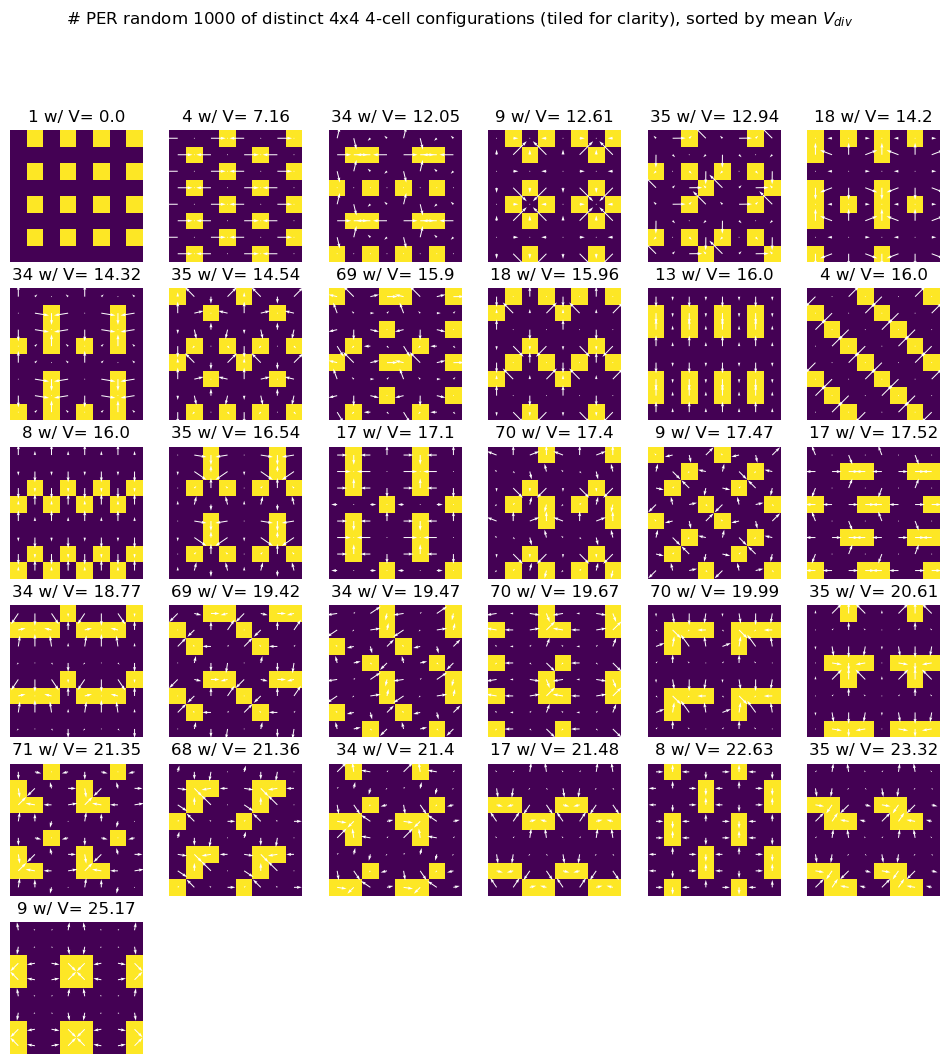

In [28]:
# Display unique configurations 
plt.figure( figsize=(12,12) )
plt.suptitle('# PER random 1000 of distinct 4x4 4-cell configurations (tiled for clarity), sorted by mean $V_{div}$');

for index, row in df_uniq_sort.iterrows():
    plt.subplot(6,6,index)
    tilepcolor(row['w']); tilequiv(row.u, row.v, color='white')
    plt.axis('off'); 
    # Title: meanV 
    plt.title( str( int(row.Nconfigs *1000/NSAMP) )+' w/ V= '+str( np.round(row.MeanV,2) ) );

In [29]:
# OK, here they all are, 31 of them 
#df_uniq_sort.iloc[:,0:8]

In [30]:
# The 3 with WS=16, how do they differ? 
#uniqs = df_uniq_sort.iloc[:,0:10]
#uniqs[ uniqs['MeanV'].between(15.99,16.01) ]

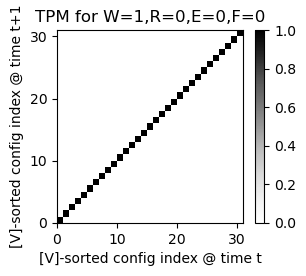

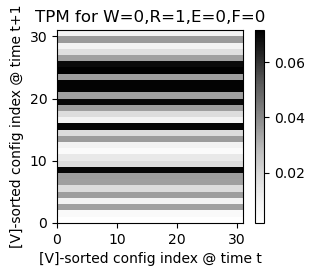

In [93]:
# TPMs for pure persistence and pure random 
TPM = np.diag( df_uniq_sort.Nconfigs/df_uniq_sort.Nconfigs.sum() ) # Pure Randomness
plt.figure( figsize=(3,2.5) )
plt.pcolormesh( TPM >0 , cmap='Greys' ); 
plt.colorbar();
plt.xlabel('[V]-sorted config index @ time t'); plt.ylabel('[V]-sorted config index @ time t+1'); 
plt.title('TPM for W=1,R=0,E=0,F=0');

for i in range(df_uniq_sort.Nconfigs.size):
    TPM[:,i] = df_uniq_sort.Nconfigs/df_uniq_sort.Nconfigs.sum() # Pure Persistence
plt.figure( figsize=(3,2.5) )
plt.pcolormesh( TPM , cmap='Greys' ); 
plt.colorbar();
plt.xlabel('[V]-sorted config index @ time t'); plt.ylabel('[V]-sorted config index @ time t+1'); 
plt.title('TPM for W=0,R=1,E=0,F=0');

In [ ]:
# Example from Gemini of houw to count redundant configs 

import pandas as pd
# Sample DataFrame (replace with your actual DataFrame)
data = {'id': [1, 2, 3, 4, 5, 6, 7],
        'T': ['apple', 'banana', 'cherry', 'apple', 'date', 'fig', 'banana'],
        'value': [10, 20, 30, 40, 50, 60, 70]}
df = pd.DataFrame(data)

# Solution
df_result = df.drop_duplicates(subset=['T']).merge(
    df['T'].value_counts().reset_index(name='T_redundancy_count'),
    on='T',
    how='left'
)

print(df_result)